In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
import easyocr

In [2]:
pip install -U --force-reinstall charset-normalizer 

  Obtaining dependency information for charset-normalizer from https://files.pythonhosted.org/packages/6b/b2/9d0c8fe83572a37bd66150399e289d8e96d62eca359ffa67c021b4120887/charset_normalizer-3.2.0-cp38-cp38-win_amd64.whl.metadata
  Using cached charset_normalizer-3.2.0-cp38-cp38-win_amd64.whl.metadata (31 kB)
Using cached charset_normalizer-3.2.0-cp38-cp38-win_amd64.whl (96 kB)
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 3.2.0
    Uninstalling charset-normalizer-3.2.0:
      Successfully uninstalled charset-normalizer-3.2.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
# settings 
INPUT_WIDTH = 640
INPUT_HEIGHT = 640

(-0.5, 399.5, 239.5, -0.5)

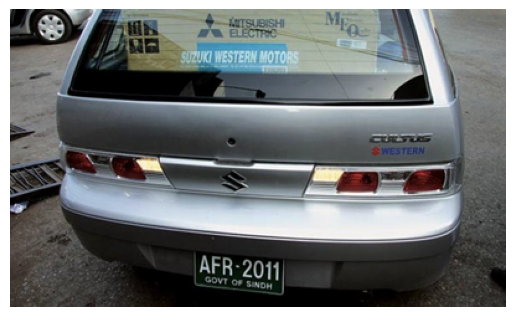

In [112]:
# LOAD the IMAGE
img = cv2.imread("dataset\Images_1\Cars17.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")

In [113]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX("best1.onnx")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

(-0.5, 399.5, 399.5, -0.5)

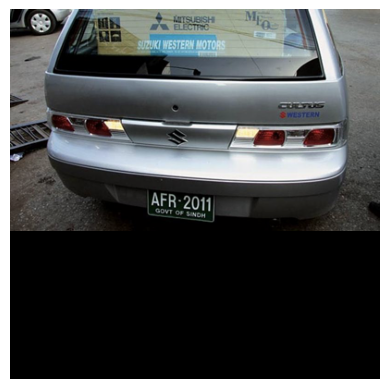

In [114]:
# CONVERT IMAGE TO YOLO FORMAT
image = img.copy()
row, col, d = image.shape

max_rc = max(row, col)
input_image = np.zeros((max_rc, max_rc, 3), dtype=np.uint8)
input_image[0:row, 0:col] = image
plt.imshow(input_image)
plt.axis("off")

In [115]:
# GET PREDICTIONS FROM YOLO MODEL

blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
net.setInput(blob)
preds = net.forward()
detections = preds[0]

In [116]:
detections

array([[9.10398197e+00, 4.99253273e+00, 3.04399834e+01, 2.84789696e+01,
        2.35917090e-04, 9.99932528e-01],
       [1.52124815e+01, 3.51735020e+00, 3.38500214e+01, 2.05316372e+01,
        1.60996206e-04, 9.99947071e-01],
       [2.11156120e+01, 5.19530392e+00, 2.87316475e+01, 1.88822498e+01,
        4.40364092e-05, 9.99958992e-01],
       ...,
       [5.54316162e+02, 6.17977295e+02, 2.15532913e+02, 1.85319565e+02,
        2.17999564e-04, 9.99974847e-01],
       [5.93229004e+02, 6.19935791e+02, 2.01969421e+02, 2.13462463e+02,
        3.21313390e-04, 9.99967456e-01],
       [6.24002808e+02, 6.15307434e+02, 2.76924988e+02, 1.47333176e+02,
        6.80816127e-04, 9.99979734e-01]], dtype=float32)

In [117]:
# FILTER DETECTIONS BASED ON CONFIDENCE PROBABILITY SCORE
# center_x, center_y, w, h, conf, probab.

boxes = []
confidences = []

image_w, image_h = input_image.shape[:2]
x_factor = image_w / INPUT_WIDTH
y_factor = image_h / INPUT_HEIGHT

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4] # confidence of detecting license plate
    if confidence > 0.4:
        class_score = row[5] # probability score of license plate
        if class_score > 0.25:
            cx, cy, w, h = row[0:4]
            
            left = int((cx - 0.5 * w) * x_factor)
            top = int((cy - 0.5 * h) * y_factor)
            width = int(w * x_factor)
            height = int(h * y_factor)
            box = np.array([left,top,width,height])
            
            confidences.append(confidence)
            boxes.append(box)

In [118]:
boxes[:5]

[array([146, 192,  74,  42]),
 array([149, 193,  69,  38]),
 array([143, 193,  82,  39]),
 array([142, 195,  82,  34]),
 array([141, 195,  86,  35])]

In [119]:
# Clean
boxes_np = np.array(boxes).tolist()
confidences_np = np.array(confidences).tolist()

In [120]:
boxes_np[:5]

[[146, 192, 74, 42],
 [149, 193, 69, 38],
 [143, 193, 82, 39],
 [142, 195, 82, 34],
 [141, 195, 86, 35]]

In [121]:
confidences_np[:5]

[0.517338216304779,
 0.49714815616607666,
 0.778965175151825,
 0.6138639450073242,
 0.8936393857002258]

In [122]:
# NMS
index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45).flatten()

In [123]:
index

array([4])

(-0.5, 399.5, 239.5, -0.5)

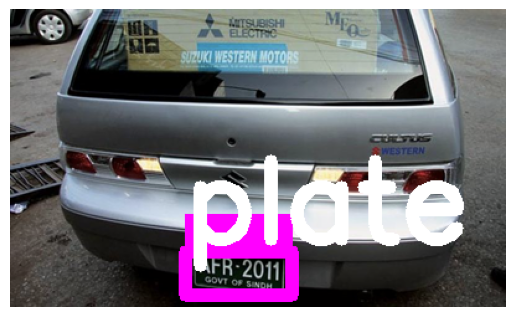

In [124]:
# Draw
for ind in index:
    x,y,w,h = boxes_np[ind]
    bb_conf = confidences_np[ind]
    conf_text = "plate {:.0f}%".format(bb_conf*100)

    
    cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,255), 10)
    cv2.rectangle(image, (x,y-30), (x+w, y), (255,0,255),-1)
    
    cv2.putText(image, conf_text, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255),10)
    
plt.imshow(image)
plt.axis("off")

## Clean Code and Creating Functions

In [125]:
def get_detections(img, net):
    # CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row, col)
    input_image = np.zeros((max_rc, max_rc, 3), dtype=np.uint8)
    input_image[0:row, 0:col] = image
    
    # GET PREDICTIONS FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

In [126]:
def non_maximum_supression(input_image, detections):

    # FILTER DETECTIONS BASED ON CONFIDENCE PROBABILITY SCORE
    # center_x, center_y, w, h, conf, probab.

    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w / INPUT_WIDTH
    y_factor = image_h / INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy, w, h = row[0:4]

                left = int((cx - 0.5 * w) * x_factor)
                top = int((cy - 0.5 * h) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)
    # Clean
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # NMS
    index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45).flatten()
    
    return boxes_np, confidences_np, index

In [127]:
def drawings(image, boxes_np, confidences_np, index):
    # Draw
    for ind in index:
        x,y,w,h = boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = "plate {:.0f}%".format(bb_conf*100)


        cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,255), 15)
        cv2.rectangle(image, (x,y-30), (x+w, y), (255,0,255),-1)

        cv2.putText(image, conf_text, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,255,255),10)
        
    return image

## Predictions

In [128]:
def yolo_predictions(img, net):
    
    # BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ## step-1: detections
    input_image, detections = get_detections(img, net)

    ## step-2: NMS (Non Maximum Supression)
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)

    ## step-3: Drawings
    result_img = drawings(img, boxes_np, confidences_np, index)
    
    return result_img

## Test

In [129]:
img = cv2.imread("dataset\Images_1\Cars11.png")

results = yolo_predictions(img, net)

(-0.5, 399.5, 304.5, -0.5)

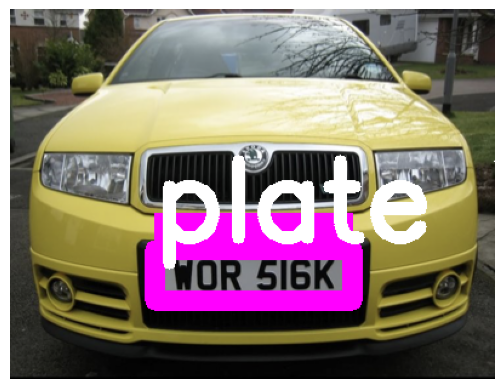

In [130]:
plt.imshow(results)
plt.axis("off")

## Extract Text

In [142]:
def extract_text(image, bbox):
    reader = easyocr.Reader(['en',])
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return ""
    else:
        reader = easyocr.Reader(['en',])
        result = reader.readtext(roi)
        #result = reader.readtext('path_to_image.jpg')
        for detection in result:
            text = detection[1]
        print(type(text))
        
        return text

In [132]:
def drawings(image, boxes_np, confidences_np, index):
    # Draw
    for ind in index:
        x,y,w,h = boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = "plate {:.0f}%".format(bb_conf*100)
        
        license_text = extract_text(image, boxes_np[ind]) # getting text

        cv2.rectangle(image, (x,y), (x+w, y+h), (255,0,255), 15)
        cv2.rectangle(image, (x,y-30), (x+w, y), (255,0,255),-1)
        
        cv2.rectangle(image, (x,y+h), (x+w, y+h+30), (0,0,0),-1) #drawing black box (text will be here)

        cv2.putText(image, conf_text, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255),3)
        
        cv2.putText(image, license_text, (x, y+h+25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0),3) # text
        
    return image

In [133]:
def yolo_predictions(img, net):
    
    # BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ## step-1: detections
    input_image, detections = get_detections(img, net)

    ## step-2: NMS (Non Maximum Supression)
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)

    ## step-3: Drawings
    result_img = drawings(img, boxes_np, confidences_np, index)
    
    return result_img

In [143]:
img = cv2.imread("C:\\Users\\rajna\\OneDrive\\Desktop\\download.jpg")

result_img = yolo_predictions(img, net)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


<class 'str'>


(-0.5, 274.5, 182.5, -0.5)

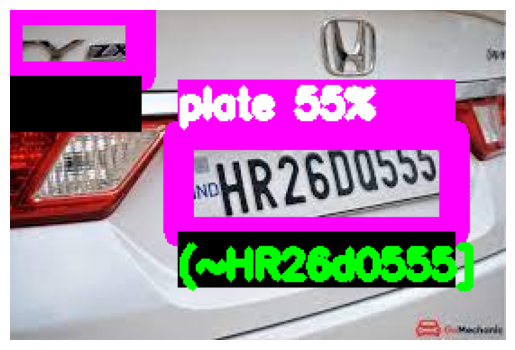

In [144]:
plt.imshow(result_img)
plt.axis("off")

## Real Time Object Detection

In [27]:
# cap = cv2.VideoCapture(video_path)
# 
# while True:
#     ret, frame = cap.read()
#     
#     if ret == False:
#         print("unable to read video")
#         break
#         
#     result = yolo_predictions(frame, net)
#     
#     cv2.namedWindow("YOLO", cv2.WINDOW_KEEPRATIO)
#     cv2.imshow("YOLO", result)
#     
#     if cv2.waitKey(1) == 27:
#         break
# 
# cv2.destroyAllWindows()
# cap.release()